In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold

In [3]:
def load_data(image_size, labels, base_path):
    X = []
    Y = []
    for label in labels:
        folderPath = os.path.join(base_path, label)
        for img_name in os.listdir(folderPath):
            img_path = os.path.join(folderPath, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            Y.append(labels.index(label))
    return np.array(X), np.array(Y)

In [4]:
image_size = 224
labels = ['covid', 'pneumonia']
base_path = '/content/drive/MyDrive/covid_pneumonia/'

# Load data
X, Y = load_data(image_size, labels, base_path)



In [5]:
from collections import Counter
# # Assume X (features) and y (labels)
X_majority = X[Y == 0]  # Majority class
X_minority = X[Y == 1]  # Minority class

# Reduce the minority class to 10% of the majority class
X_minority_downsampled, _, y_minority_downsampled, _ = train_test_split(
    X_minority, [1] * len(X_minority), test_size=0.9, random_state=42
)

# Combine with the majority class
X_imbalanced = np.vstack((X_majority, X_minority_downsampled))
Y_imbalanced = np.hstack(([0] * len(X_majority), [1] * len(X_minority_downsampled)))

print(f"Original Class Distribution: {Counter(Y)}")
print(f"Imbalanced Class Distribution: {Counter(Y_imbalanced)}")

Original Class Distribution: Counter({np.int64(0): 524, np.int64(1): 463})
Imbalanced Class Distribution: Counter({np.int64(0): 524, np.int64(1): 46})


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_imbalanced, Y_imbalanced, test_size=0.2, random_state=42)


In [8]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# train_datagen.fit(X_train)

In [9]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import time

def build_and_train_model_kfold(base_model, X, Y, X_test, Y_test, labels, model_name, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_losses = []
    conf_matrices = []
    training_times = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nTraining Fold {fold + 1}/{k_folds}...\n")

        # Splitting the dataset for this fold
        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]

        # Define the model
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        # Compile the model
        optimizer = Adam(learning_rate=0.0001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Train the model
        start_time = time.time()
        history = model.fit(
            train_datagen.flow(X_train, Y_train, batch_size=32),
            epochs=5,
            validation_data=(X_val, Y_val),
            verbose=1
        )
        training_time = time.time() - start_time
        training_times.append(training_time)

        # Evaluate on validation set
        val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=1)
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)

        print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}")
        print(f"Fold {fold + 1} Validation Loss: {val_loss:.4f}")

    # Train final model on full training set
    print("\nTraining Final Model on Full Dataset...\n")
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    history = model.fit(
        train_datagen.flow(X, Y, batch_size=32),
        epochs=5,
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print(f'Final Test Loss: {test_loss:.4f}')

    # Confusion Matrix and Classification Report
    Y_pred = model.predict(X_test)
    Y_pred_classes = (Y_pred > 0.5).astype(int)

    conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
    class_report = classification_report(Y_test, Y_pred_classes, target_names=labels)

    print(f'\nClassification Report for {model_name}:')
    print(class_report)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Summary of K-Fold Results
    avg_accuracy = np.mean(fold_accuracies)
    avg_loss = np.mean(fold_losses)
    avg_time = np.mean(training_times)

    print(f"\nAverage Validation Accuracy across {k_folds} folds: {avg_accuracy:.4f}")
    print(f"Average Validation Loss across {k_folds} folds: {avg_loss:.4f}")
    print(f"Average Training Time per fold: {avg_time:.2f} seconds")

    return history, avg_accuracy, avg_loss, conf_matrix, class_report, Y_test, Y_pred_classes


In [ ]:
# Train ResNet50 Model

# Now loop over folds instead of manually splitting
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
history, avg_accuracy, avg_loss, conf_matrix, class_report, Y_test, Y_pred_classes = build_and_train_model_kfold(
    base_model=base_model_resnet,
    X=X_train,
    Y=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    labels=labels,
    model_name='KFold_Model',
    k_folds=5
)

# history_resnet, time_resnet, conf_matrix_resnet, report_resnet, Y_test_resnet, Y_pred_resnet = build_and_train_model(base_model_resnet, X_train, Y_train, X_test, Y_test, labels, 'ResNet50')



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

Training Fold 1/5...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.8612 - loss: 2.6035 - val_accuracy: 0.9565 - val_loss: 0.1514
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step - accuracy: 0.9292 - loss: 0.1675 - val_accuracy: 0.9239 - val_loss: 0.2817
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 427ms/step - accuracy: 0.9717 - loss: 0.0615 - val_accuracy: 0.9565 - val_loss: 0.1747
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step - accuracy: 0.9940 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.0158
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0130
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0106
Fold 1 Validation Accuracy: 1.0000
Fold 1 Validation Loss: 0.0130

Training Fold 2/5...

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.7859 - loss: 1.5097 - val_accuracy: 0.9560 - val_loss: 1.9027
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 422ms/step - accuracy: 0.9909 - loss: 0

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training Fold 1/5...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.6524 - loss: 2.3669 - val_accuracy: 0.8797 - val_loss: 0.3467
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 586ms/step - accuracy: 0.8583 - loss: 0.3810 - val_accuracy: 0.8861 - val_loss: 0.2787
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step - accuracy: 0.8927 - loss: 0.2647 - val_accuracy: 0.9241 - val_loss: 0.1933
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 635ms/step - accuracy: 0.9326 - loss: 0.1874 - val_accuracy: 0.9494 - val_loss: 0.2033
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 588ms/step - accuracy: 0.9244 - loss: 0.2014 - val_accuracy: 0.9557 - val_loss: 0.1234
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.9535 - loss: 0.1349
Fold 1 Validation Accuracy: 0.9557
Fold 1 Validation Loss: 0.1234

Training Fold 2/5...

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 799ms/step - accuracy: 0.7795 - loss: 0.4699 - val_accuracy: 0.9684 - val_loss: 0.0859
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 578ms/step - accuracy: 0.9429 -

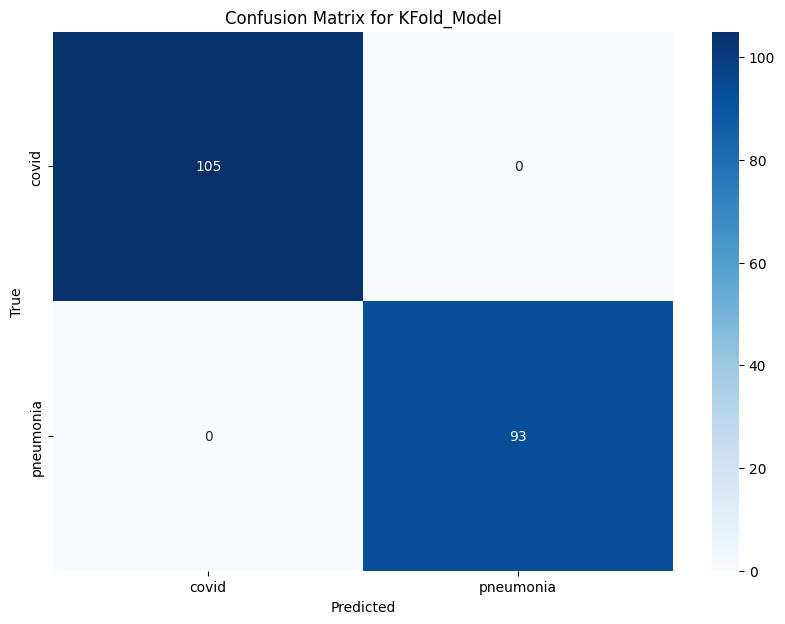


Average Validation Accuracy across 5 folds: 0.9873
Average Validation Loss across 5 folds: 0.0435
Average Training Time per fold: 105.97 seconds


In [ ]:
# Train VGG16 Model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
history, avg_accuracy, avg_loss, conf_matrix, class_report, Y_test, Y_pred_classes = build_and_train_model_kfold(
    base_model=base_model_vgg,
    X=X_train,
    Y=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    labels=labels,
    model_name='KFold_Model',
    k_folds=5
)

In [ ]:
def calculate_metrics(conf_matrix, Y_test, Y_pred_classes):
    # Sensitivity (Recall)
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

    # Specificity
    specificity = []
    for i in range(len(conf_matrix)):
        true_negatives = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
        false_positives = np.sum(np.delete(conf_matrix, i, axis=0)[:, i])
        specificity.append(true_negatives / (true_negatives + false_positives))

    # Cohen's Kappa
    kappa = cohen_kappa_score(Y_test, Y_pred_classes)

    # Classification Report (F1-score included)
    class_report_dict = classification_report(Y_test, Y_pred_classes, target_names=labels, output_dict=True)
    f1_score = {label: class_report_dict[label]['f1-score'] for label in labels}

    return sensitivity, specificity, f1_score, kappa

sensitivity_resnet, specificity_resnet, f1_score_resnet, kappa_resnet = calculate_metrics(conf_matrix_resnet, Y_test_resnet, Y_pred_resnet)
sensitivity_vgg, specificity_vgg, f1_score_vgg, kappa_vgg = calculate_metrics(conf_matrix_vgg, Y_test_vgg, Y_pred_vgg)

NameError: name 'conf_matrix_vgg' is not defined

In [ ]:
print("ResNet50 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_resnet}")
print(f"Specificity: {specificity_resnet}")
print(f"F1 Score: {f1_score_resnet}")
print(f"Cohen's Kappa: {kappa_resnet}")

print("\nVGG16 Metrics:")
print(f"Sensitivity (Recall): {sensitivity_vgg}")
print(f"Specificity: {specificity_vgg}")
print(f"F1 Score: {f1_score_vgg}")
print(f"Cohen's Kappa: {kappa_vgg}")

ResNet50 Metrics:
Sensitivity (Recall): [1. 1.]
Specificity: [1.0, 1.0]
F1 Score: {'covid': 1.0, 'pneumonia': 1.0}
Cohen's Kappa: 1.0

VGG16 Metrics:


NameError: name 'sensitivity_vgg' is not defined

In [ ]:
import numpy as np
import hashlib

def get_image_hash(image_array):
    """Compute hash of an image numpy array to detect duplicates."""
    hasher = hashlib.md5()
    hasher.update(image_array.tobytes())  # Convert image array to bytes
    return hasher.hexdigest()

def check_duplicate_images(X_train, X_val, X_test):
    """Checks for duplicate images across train, validation, and test sets."""
    sets = {'train': X_train, 'val': X_val, 'test': X_test}
    hash_dict = {}

    for split, images in sets.items():
        for i, img in enumerate(images):
            img_hash = get_image_hash(img)
            if img_hash in hash_dict:
                print(f"⚠️ Duplicate image found between {split} and {hash_dict[img_hash]}!")
            hash_dict[img_hash] = split  # Store where the hash was first seen

    print("✅ No duplicate images found between train, val, and test sets!")

# Run check
check_duplicate_images(X_train, X_val, X_test)


✅ No duplicate images found between train, val, and test sets!
